# First example of causal inference

Goal of this notebook:

[x] create synthetic data from a given causal structure;
[x] create a population with bdb;
[ ] anlyze
[ ] show CMI (via plugin)
[ ] create venture model for structure;
[ ] observe 
[ ] show causal inferrence with CMI (posterior walk);
[ ] plot posterior distribution of DAGS (using a foreing inference SP)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%%capture
%load_ext iventure.magics
%matplotlib inline

## 1. Synthetic Data

The following graphical model is used to generate N datapoints: 

![title](img/causal_example.png)

using the following linear generative system:

$ a := \eta_a$ where $\eta_a \sim \mathcal{N}(0,2)$

$ b := \eta_b$ where $\eta_b \sim \mathcal{N}(0,2)$

$ c := \eta_c$ where $\eta_c \sim \mathcal{N}(0,2)$

$ d := 3c + e_d$ where $\eta_d \sim \mathcal{N}(0,1)$

$ e := \eta_e$ where $\eta_e \sim \mathcal{N}(0,2)$

$ f := \eta_f$ where $\eta_f \sim \mathcal{N}(0,2)$

$ g := 2e + + 2f + e_g$ where $\eta_g \sim \mathcal{N}(0,1)$



In [3]:
N = 100

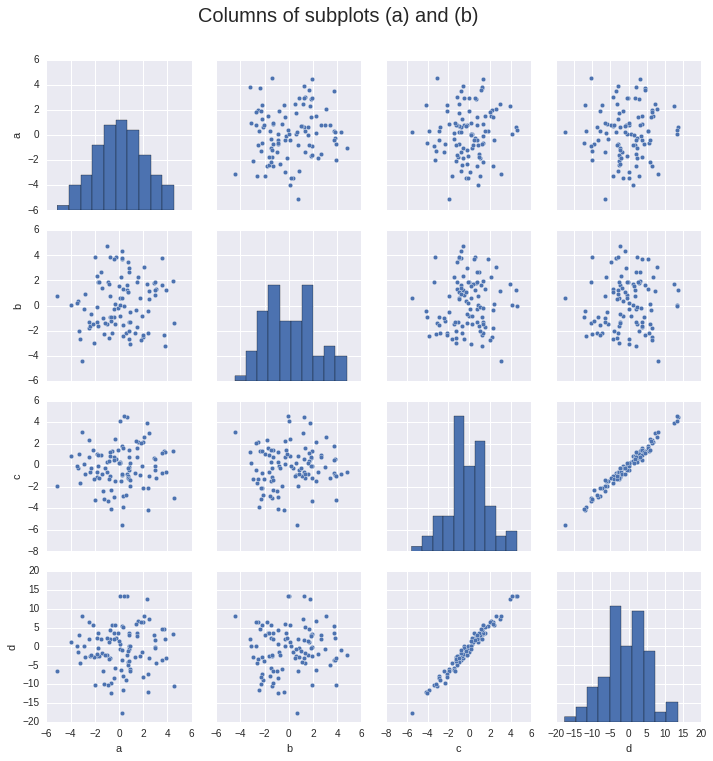

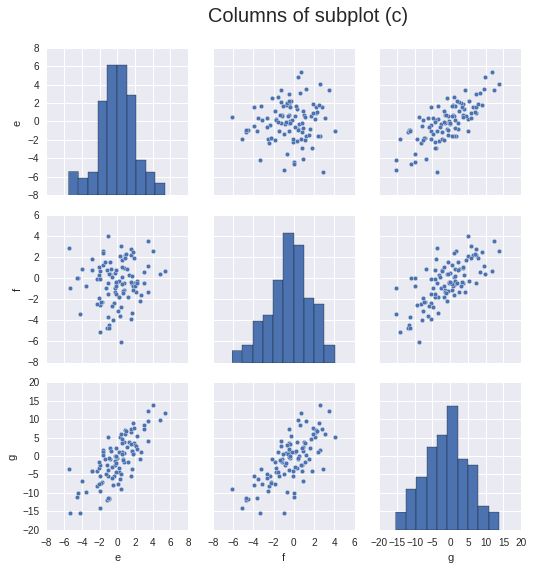

In [4]:
np.random.seed(seed=0)
a  = np.random.normal(0,2, (N,))
b  = np.random.normal(0,2, (N,))
c  = np.random.normal(0,2, (N,))
d  = 3*c + np.random.normal(0,1, (N,))
e  = np.random.normal(0,2, (N,))
f  = np.random.normal(0,2, (N,))
g =  2*e + 2*f + np.random.normal(0,1, (N,))
df = pd.DataFrame({"a":a, "b":b, "c": c, "d":d, "e":e, "f": f, "g":g})
df.to_csv("csv_files/causal_linear.csv", index=False)
sns.pairplot(data=pd.DataFrame({"a":a, "b":b, "c": c, "d":d}))
plt.title("Columns of subplots (a) and (b)", fontsize=20, y=3.48, x=-1.5)
plt.figure()
sns.pairplot(data=pd.DataFrame({"e":e, "f": f, "g":g}))
plt.title("Columns of subplot (c)", fontsize=20, y=2.28, x=-0.5)

## 2. BDB - Population and Analysis 

In [5]:
%bayesdb -j bdb_files/causal_linear.bdb

u'Loaded: bdb_files/causal_linear.bdb'

## (a) two independent nodes

In [6]:
%ripl --seed 0 --plugins   causal_inference_plugin.py 

Set seed of a new VentureScript RIPL to 0.00.
Loading plugin: causal_inference_plugin.py


In [7]:
%%venturescript
define list_of_nodes = ["a", "b"];
define population = "causal_linear_population";
define metamodel = "causal_linear_cc";
define path_to_bdb_file = "bdb_files/causal_linear.bdb";
define list_of_cmi_queries = get_cmi_queries(list_of_nodes, population);

In [8]:
%%venturescript
assume number_nodes = size(${list_of_nodes});
assume get_causal_ordering = (list_of_nodes) -> {
    if(size(list_of_nodes)==1) {
        list_of_nodes}
    else {
        if(size(list_of_nodes)==2){// well, [1] + [2] is [3] whereas 
                                   // [1] + [2,3] shows the desired behaviour
                                   // namely [1,2,3]. Therefore, we need another
                                   // condition to catch this.
            if(flip()) {list_of_nodes} else {[list_of_nodes[1], list_of_nodes[0]]}}
        else {                  
            random_index ~ uniform_discrete(0, size(list_of_nodes));
            popped =  pop(list_of_nodes, random_index);
            [popped[0]] + get_causal_ordering(popped[1])}}
    
};



assume causal_ordering = get_causal_ordering(arange(number_nodes));

assume find = (list, item) -> {find_helper(to_list(list), item, 0)};
assume find_helper = (list, item, index) -> {
       if(list[0]==item)
            {index}
       else
            {find_helper(rest(list), item, index + 1)}};

assume edge = mem((parent, child) -> {
   causal_ordering_parent = integer(find(causal_ordering, parent));
   causal_ordering_child = integer(find(causal_ordering, child));
   if (causal_ordering_parent >= causal_ordering_child){
            False
        }
   else {
            flip() 
        }});

assume DAG = mapv((i) -> {
        mapv((j) -> {edge(real(i),real(j))}, arange(number_nodes))},
        arange(number_nodes));



assume observation_function = make_observation_function(
                              ${population},
                              ${metamodel},
                              ${path_to_bdb_file} ,
                              ${list_of_cmi_queries},
                              ${list_of_nodes});

observe observation_function(DAG) = True;

Running the following query:
DROP TABLE IF EXISTS mi_a_b;
Running the following query:
CREATE TABLE  mi_a_b AS
            SIMULATE
                MUTUAL INFORMATION OF a WITH b
                USING 100 SAMPLES
                AS mi FROM MODELS OF causal_linear_population;


In [9]:
%%venturescript
mh(default, all, 10);

In [10]:
%%venturescript
define posterior_samples = run(mapM((_)->{
    mh(default, all, 1);
    sample(dag_to_dot_notation(DAG, ${list_of_nodes}))
    }, arange(20)));

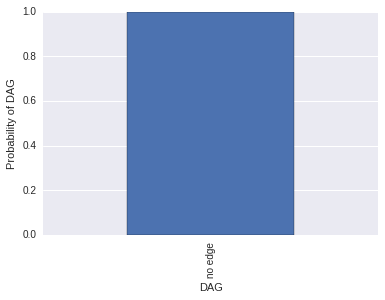

In [11]:
%%venturescript
plot_posterior_dags(posterior_samples);

## (b) two dependent nodes

In [12]:
%ripl --seed 0 --plugins   causal_inference_plugin.py 

Set seed of a new VentureScript RIPL to 0.00.
Loading plugin: causal_inference_plugin.py


In [13]:
%%venturescript
define list_of_nodes = ["c", "d"];
define population = "causal_linear_population";
define metamodel = "causal_linear_cc";
define path_to_bdb_file = "bdb_files/causal_linear.bdb";
define list_of_cmi_queries = get_cmi_queries(list_of_nodes, population);

In [14]:
%%venturescript
assume number_nodes = size(${list_of_nodes});
assume get_causal_ordering = (list_of_nodes) -> {
    if(size(list_of_nodes)==1) {
        list_of_nodes}
    else {
        if(size(list_of_nodes)==2){// well, [1] + [2] is [3] whereas 
                                   // [1] + [2,3] shows the desired behaviour
                                   // namely [1,2,3]. Therefore, we need another
                                   // condition to catch this.
            if(flip()) {list_of_nodes} else {[list_of_nodes[1], list_of_nodes[0]]}}
        else {                  
            random_index ~ uniform_discrete(0, size(list_of_nodes));
            popped =  pop(list_of_nodes, random_index);
            [popped[0]] + get_causal_ordering(popped[1])}}
    
};



assume causal_ordering = get_causal_ordering(arange(number_nodes));

assume find = (list, item) -> {find_helper(to_list(list), item, 0)};
assume find_helper = (list, item, index) -> {
       if(list[0]==item)
            {index}
       else
            {find_helper(rest(list), item, index + 1)}};

assume edge = mem((parent, child) -> {
   causal_ordering_parent = integer(find(causal_ordering, parent));
   causal_ordering_child = integer(find(causal_ordering, child));
   if (causal_ordering_parent >= causal_ordering_child){
            False
        }
   else {
            flip() 
        }});

assume DAG = mapv((i) -> {
        mapv((j) -> {edge(real(i),real(j))}, arange(number_nodes))},
        arange(number_nodes));



assume observation_function = make_observation_function(
                              ${population},
                              ${metamodel},
                              ${path_to_bdb_file} ,
                              ${list_of_cmi_queries},
                              ${list_of_nodes});

observe observation_function(DAG) = True;

Running the following query:
DROP TABLE IF EXISTS mi_c_d;
Running the following query:
CREATE TABLE  mi_c_d AS
            SIMULATE
                MUTUAL INFORMATION OF c WITH d
                USING 100 SAMPLES
                AS mi FROM MODELS OF causal_linear_population;


In [15]:
%%venturescript
mh(default, all, 10);

In [16]:
%%venturescript
define posterior_samples = run(mapM((_)->{
    mh(default, all, 1);
    sample(dag_to_dot_notation(DAG, ${list_of_nodes}))
    }, arange(20)));

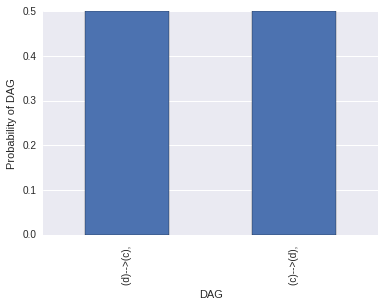

In [17]:
%%venturescript
plot_posterior_dags(posterior_samples);

## (c) V structure

In [18]:
%ripl --seed 0 --plugins   causal_inference_plugin.py 

Set seed of a new VentureScript RIPL to 0.00.
Loading plugin: causal_inference_plugin.py


In [19]:
%%venturescript
define list_of_nodes = ["e", "f", "g"];
define population = "causal_linear_population";
define metamodel = "causal_linear_cc";
define path_to_bdb_file = "bdb_files/causal_linear.bdb";
define list_of_cmi_queries = get_cmi_queries(list_of_nodes, population);

In [20]:
%%venturescript
list_of_cmi_queries[1]

'CREATE TABLE  mi_e_f AS\n            SIMULATE\n                MUTUAL INFORMATION OF e WITH f\n                USING 100 SAMPLES\n                AS mi FROM MODELS OF causal_linear_population;'

In [21]:
%%venturescript
assume number_nodes = size(${list_of_nodes});
assume get_causal_ordering = (list_of_nodes) -> {
    if(size(list_of_nodes)==1) {
        list_of_nodes}
    else {
        if(size(list_of_nodes)==2){// well, [1] + [2] is [3] whereas 
                                   // [1] + [2,3] shows the desired behaviour
                                   // namely [1,2,3]. Therefore, we need another
                                   // condition to catch this.
            if(flip()) {list_of_nodes} else {[list_of_nodes[1], list_of_nodes[0]]}}
        else {                  
            random_index ~ uniform_discrete(0, size(list_of_nodes));
            popped =  pop(list_of_nodes, random_index);
            [popped[0]] + get_causal_ordering(popped[1])}}
    
};



assume causal_ordering = get_causal_ordering(arange(number_nodes));

assume find = (list, item) -> {find_helper(to_list(list), item, 0)};
assume find_helper = (list, item, index) -> {
       if(list[0]==item)
            {index}
       else
            {find_helper(rest(list), item, index + 1)}};

assume edge = mem((parent, child) -> {
   causal_ordering_parent = integer(find(causal_ordering, parent));
   causal_ordering_child = integer(find(causal_ordering, child));
   if (causal_ordering_parent >= causal_ordering_child){
            False
        }
   else {
            flip() 
        }});

assume DAG = mapv((i) -> {
        mapv((j) -> {edge(real(i),real(j))}, arange(number_nodes))},
        arange(number_nodes));



assume observation_function = make_observation_function(
                              ${population},
                              ${metamodel},
                              ${path_to_bdb_file} ,
                              ${list_of_cmi_queries},
                              ${list_of_nodes});

In [22]:
ripl = %get_ripl
ripl.execute_program("""
observe observation_function(DAG) = True;""")

Running the following query:
DROP TABLE IF EXISTS mi_e_f;
Running the following query:
CREATE TABLE  mi_e_f AS
            SIMULATE
                MUTUAL INFORMATION OF e WITH f
                USING 100 SAMPLES
                AS mi FROM MODELS OF causal_linear_population;
Running the following query:
DROP TABLE IF EXISTS mi_e_g;
Running the following query:
CREATE TABLE  mi_e_g AS
            SIMULATE
                MUTUAL INFORMATION OF e WITH g
                USING 100 SAMPLES
                AS mi FROM MODELS OF causal_linear_population;
Running the following query:
DROP TABLE IF EXISTS mi_f_g;
Running the following query:
CREATE TABLE  mi_f_g AS
            SIMULATE
                MUTUAL INFORMATION OF f WITH g
                USING 100 SAMPLES
                AS mi FROM MODELS OF causal_linear_population;
Running the following query:
DROP TABLE IF EXISTS mi_e_f_given_g;
Running the following query:
CREATE TABLE  mi_e_f_given_g AS
            SIMULATE
                MUTUAL I

[{'directive_id': 52,
  'value': {'subtype': <venture.lite.types.NumberType at 0x7f6b6b6e1090>,
   'type': 'array_unboxed',
   'value': [-4.3581221257263509]}}]

In [26]:
ripl.infer("mh(default, all, 100)")

[344.0]

In [27]:
%%venturescript
define posterior_samples = run(mapM((_)->{
    mh(default, all, 1);
    sample(dag_to_dot_notation(DAG, ${list_of_nodes}))
    }, arange(50)));

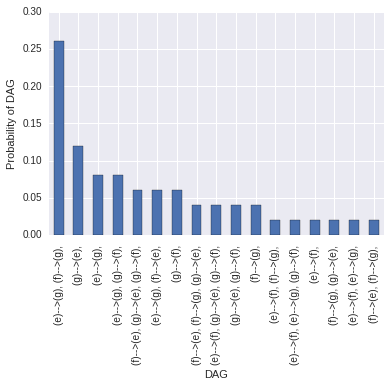

In [28]:
%%venturescript
plot_posterior_dags(posterior_samples);